# Model for minor events ('swarming', 'feeding', 'honey') that require small time chunks
Works better with month and hour data.
96% accuracy on test set.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from timestamps import BeeTimestamps, segments_to_features_and_labels, randomize_segments, balance_segments
import matplotlib.pyplot as plt
import models

SEED = 2
SEGMENT_SIZE = 24
events = ['swarming', 'feeding', 'honey']
timestamps = BeeTimestamps(
    'timestamps-v4.json', 
    './dataset/transformed_populated/interval_15m', 
    events=events, 
    features=['weight_kg_3_pct', 'month', 'hour'],
    step=1
)
segments = timestamps.get_segments_for_minor_events(
    segment_size=SEGMENT_SIZE, 
    hours=8
)
print("Segments: ", len(segments))
print(f"Segments with swarming: {len([segment for segment in segments if segment.get_label()['swarming'] == 1])}")
print(f"Segments with feeding: {len([segment for segment in segments if segment.get_label()['feeding'] == 1])}")
print(f"Segments with treatment: {len([segment for segment in segments if segment.get_label()['treatment'] == 1])}")
print(f"Segments with honey: {len([segment for segment in segments if segment.get_label()['honey'] == 1])}")

Segments:  1215
Segments with swarming: 110
Segments with feeding: 381
Segments with treatment: 0
Segments with honey: 22


In [2]:
random_segments = randomize_segments(segments, seed=SEED)
balanced_segments = balance_segments(random_segments, events=events, min_count=120)
print(f"Balanced segments: {len(balanced_segments)}")

features, labels = segments_to_features_and_labels(balanced_segments)
print(f"Features: {features.shape}, Labels: {labels.shape}")
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=SEED)
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
print(f"Sequence length: {sequence_length}, N features: {n_features}, N outputs: {n_outputs}")

Balanced segments: 372
Features: (372, 24, 3), Labels: (372, 3)
Sequence length: 24, N features: 3, N outputs: 3


In [3]:
train_positive = np.sum(np.any(y_train == 1, axis=1))
test_positive = np.sum(np.any(y_test == 1, axis=1))
training_samples_with_swarming = np.sum(np.all(y_train == [1, 0, 0], axis=1))
test_samples_with_swarming = np.sum(np.all(y_test == [1, 0, 0], axis=1))
training_samples_with_feeding = np.sum(np.all(y_train == [0, 1, 0], axis=1))
test_samples_with_feeding = np.sum(np.all(y_test == [0, 1, 0], axis=1))
training_samples_with_honey = np.sum(np.all(y_train == [0, 0, 1], axis=1))
test_samples_with_honey = np.sum(np.all(y_test == [0, 0, 1], axis=1))
print(f"Training samples with positive labels: {train_positive} out of {len(y_train)} ({train_positive/len(y_train)*100:.1f}%)")
print(f"Test samples with positive labels: {test_positive} out of {len(y_test)} ({test_positive/len(y_test)*100:.1f}%)")
print()
print(f"Training samples with swarming event: {training_samples_with_swarming} out of {len(y_train)} ({training_samples_with_swarming/len(y_train)*100:.1f}%)")
print(f"Test samples with swarming event: {test_samples_with_swarming} out of {len(y_test)} ({test_samples_with_swarming/len(y_test)*100:.1f}%)")
print(f"Training samples with feeding event: {training_samples_with_feeding} out of {len(y_train)} ({training_samples_with_feeding/len(y_train)*100:.1f}%)")
print(f"Test samples with feeding event: {test_samples_with_feeding} out of {len(y_test)} ({test_samples_with_feeding/len(y_test)*100:.1f}%)")
print(f"Training samples with honey event: {training_samples_with_honey} out of {len(y_train)} ({training_samples_with_honey/len(y_train)*100:.1f}%)")
print(f"Test samples with honey event: {test_samples_with_honey} out of {len(y_test)} ({test_samples_with_honey/len(y_test)*100:.1f}%)")


Training samples with positive labels: 199 out of 297 (67.0%)
Test samples with positive labels: 53 out of 75 (70.7%)

Training samples with swarming event: 90 out of 297 (30.3%)
Test samples with swarming event: 20 out of 75 (26.7%)
Training samples with feeding event: 90 out of 297 (30.3%)
Test samples with feeding event: 30 out of 75 (40.0%)
Training samples with honey event: 19 out of 297 (6.4%)
Test samples with honey event: 3 out of 75 (4.0%)


In [4]:
model = models.lstm_v2(
    SEGMENT_SIZE=SEGMENT_SIZE, 
    sequence_length=sequence_length, 
    n_features=n_features, 
    n_outputs=n_outputs
)

history = model.fit(X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    # validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[models.early_stopping, models.reduce_lr]
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3413 - auc: 0.5466 - loss: 2.4158 - precision: 0.2617 - recall: 0.5427 - val_accuracy: 0.0333 - val_auc: 0.2572 - val_loss: 2.2146 - val_precision: 0.0741 - val_recall: 0.1429 - learning_rate: 5.0000e-04
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4332 - auc: 0.6419 - loss: 2.2485 - precision: 0.3041 - recall: 0.7281 - val_accuracy: 0.2500 - val_auc: 0.3963 - val_loss: 2.1681 - val_precision: 0.1404 - val_recall: 0.3810 - learning_rate: 5.0000e-04
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5480 - auc: 0.7360 - loss: 2.1149 - precision: 0.3200 - recall: 0.7999 - val_accuracy: 0.2500 - val_auc: 0.4150 - val_loss: 2.1208 - val_precision: 0.1441 - val_recall: 0.4048 - learning_rate: 5.0000e-04
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5554 - auc: 0.7074 - loss: 2.0312 - precision: 0.3545 - recall: 0.7476 - val_accuracy: 0.2500 - val_auc: 0.4352 - val_loss: 2.0

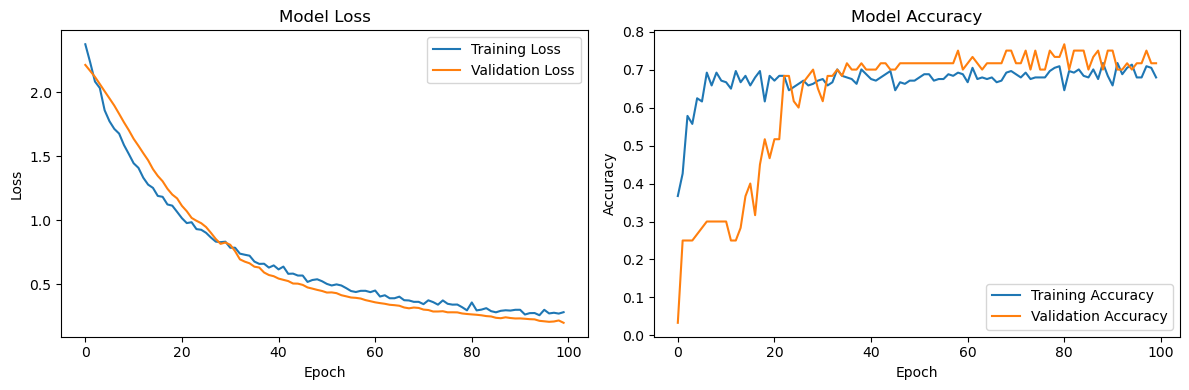

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7417 - auc: 0.9997 - loss: 0.2077 - precision: 0.9433 - recall: 1.0000 

Test accuracy: 0.7333


In [5]:
models.visualize_training(history)
# Evaluate on test set
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_accuracy:.4f}')

In [6]:
# For multi-label classification, we need to evaluate each class separately
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report for each event type
for i, event in enumerate(events):
    print(f"\nClassification Report for {event}:")
    print(classification_report(y_test[:, i], y_pred_classes[:, i]))
    
    # Calculate and print accuracy for this event
    accuracy = accuracy_score(y_test[:, i], y_pred_classes[:, i])
    print(f"Accuracy for {event}: {accuracy:.4f}")

# Print overall accuracy (all classes predicted correctly)
overall_accuracy = np.all(y_test == y_pred_classes, axis=1).mean()
print(f"\nOverall accuracy (all classes correct): {overall_accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

Classification Report for swarming:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        55
           1       0.95      1.00      0.98        20

    accuracy                           0.99        75
   macro avg       0.98      0.99      0.98        75
weighted avg       0.99      0.99      0.99        75

Accuracy for swarming: 0.9867

Classification Report for feeding:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        30

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75

Accuracy for feeding: 1.0000

Classification Report for honey:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        72
           1       0.60      1.00

In [7]:
# Find indices where predictions don't match actual values
incorrect_indices = np.where(~np.all(y_test == y_pred_classes, axis=1))[0]

print("\nIncorrect Predictions:")
print("-" * 80)
print(f"{'Index':<10}{'Expected':<40}{'Predicted':<40}")
print("-" * 80)

for idx in incorrect_indices:
    # Get the actual and predicted labels for this sample
    actual = y_test[idx]
    predicted = y_pred_classes[idx]
    
    # Convert to event names
    actual_events = [events[i] for i in range(len(events)) if actual[i] == 1]
    predicted_events = [events[i] for i in range(len(events)) if predicted[i] == 1]
    
    # Format as strings
    actual_str = ", ".join(actual_events) if actual_events else "None"
    predicted_str = ", ".join(predicted_events) if predicted_events else "None"
    
    print(f"{idx:<10}{actual_str:<40}{predicted_str:<40}")

print(f"\nTotal incorrect predictions: {len(incorrect_indices)} out of {len(y_test)} test samples")



Incorrect Predictions:
--------------------------------------------------------------------------------
Index     Expected                                Predicted                               
--------------------------------------------------------------------------------
8         None                                    honey                                   
18        None                                    honey                                   
72        None                                    swarming                                

Total incorrect predictions: 3 out of 75 test samples


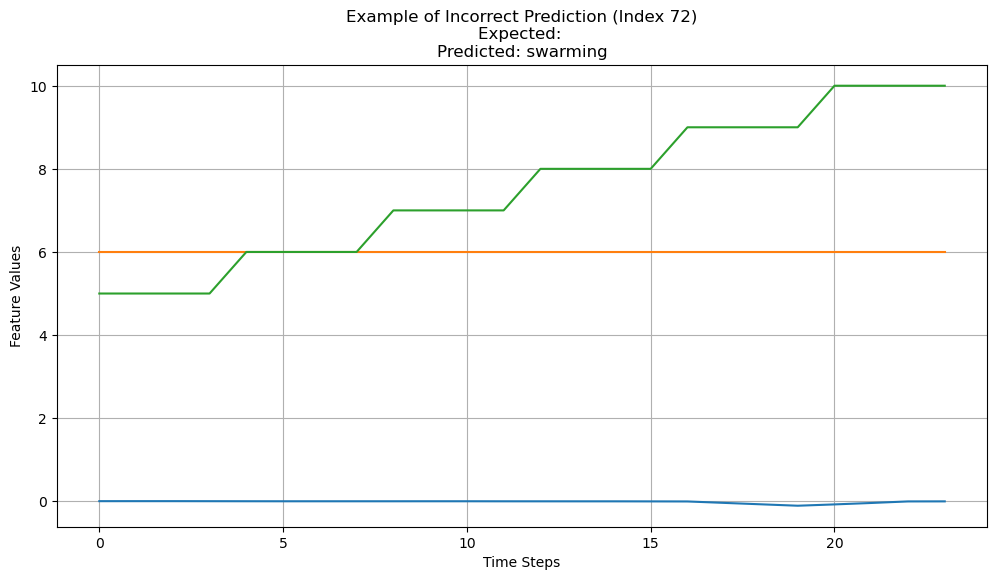

In [11]:
# Plot a few examples of incorrect predictions
plt.figure(figsize=(12, 6))

# Get the first incorrect prediction
idx = incorrect_indices[2]

# Plot the features for this example
plt.plot(X_test[idx])
plt.title(f'Example of Incorrect Prediction (Index {idx})\n' + 
          f'Expected: {", ".join([events[i] for i in range(len(events)) if y_test[idx][i] == 1])}\n' +
          f'Predicted: {", ".join([events[i] for i in range(len(events)) if y_pred_classes[idx][i] == 1])}')
plt.xlabel('Time Steps')
plt.ylabel('Feature Values')
plt.grid(True)
plt.show()

